In [ ]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms


In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 10, 3),  # 28x28 output 26x26 RF : 3x3
            nn.ReLU(),
            nn.BatchNorm2d(10),            
           
            nn.Conv2d(10, 10, 3), # 26x26 output 24x24 RF : 5x5
            nn.ReLU(),
            nn.BatchNorm2d(10),            
           
            nn.Conv2d(10, 10, 3), # 24x24 output 22x22 RF : 7x7
            nn.ReLU(),
            nn.BatchNorm2d(10),
            nn.Dropout2d(0.1),        
        )

        self.trans1 = nn.Sequential(

            nn.AvgPool2d(2, 2),  # 22x22 output - 11x11 RF 14x14

        )

        self.conv2 =  nn.Sequential(

            nn.Conv2d(10, 10, 3), # 11x11 output - 9x9 RF 16x16
            nn.ReLU(),
            nn.BatchNorm2d(10),            
            
            nn.Conv2d(10, 10, 3),  # 9x9 output - 7x7 RF 18x18
            nn.ReLU(),
            nn.BatchNorm2d(10),
            nn.Dropout2d(0.1),
            
        )

        self.trans2 = nn.Sequential(
            
            nn.AvgPool2d(2, stride=2, padding=0)
        )
        self.fc = nn.Linear(10*3*3,10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.trans1(x)
        x = self.conv2(x)
        x = self.trans2(x)
        x = x.view(x.size(0),-1)
        x = self.fc(x)
        return F.log_softmax(x,dim=1)

In [ ]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 26, 26]             100
              ReLU-2           [-1, 10, 26, 26]               0
       BatchNorm2d-3           [-1, 10, 26, 26]              20
            Conv2d-4           [-1, 10, 24, 24]             910
              ReLU-5           [-1, 10, 24, 24]               0
       BatchNorm2d-6           [-1, 10, 24, 24]              20
            Conv2d-7           [-1, 10, 22, 22]             910
              ReLU-8           [-1, 10, 22, 22]               0
       BatchNorm2d-9           [-1, 10, 22, 22]              20
        Dropout2d-10           [-1, 10, 22, 22]               0
        AvgPool2d-11           [-1, 10, 11, 11]               0
           Conv2d-12             [-1, 10, 9, 9]             910
             ReLU-13             [-1, 10, 9, 9]               0
      BatchNorm2d-14             [-1, 1

In [ ]:


torch.manual_seed(1)
batch_size = 128

kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                    transform=transforms.Compose([
                        #transforms.RandomRotation((-6.9, 6.9), fill=(1,)),                                        
                        #transforms.RandomAffine(degees=10, shear=10, translate=(0.1, 0.1), scale=(0.8, 1.2)),
                        #transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.1),
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])),
    batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])),
    batch_size=batch_size, shuffle=True, **kwargs)


In [ ]:
from tqdm import tqdm
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    pbar = tqdm(train_loader)
    train_loss = 0
    correct = 0

    for batch_idx, (data, target) in enumerate(pbar):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target) 
        train_loss += loss.item()       
        loss.backward()
        optimizer.step()
        
        pbar.set_description(desc= f'loss={loss.item()} batch_id={batch_idx}')        
        pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
        correct += pred.eq(target.view_as(pred)).sum().item()

    train_loss /= len(train_loader.dataset)
    print('\nTrain set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        train_loss, correct, len(train_loader.dataset),
        100. * correct / len(train_loader.dataset)))
    return train_loss, 100.*correct/len(train_loader.dataset)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    return test_loss, 100.*correct/len(test_loader.dataset)

In [ ]:

model = Net().to(device)
lr = 0.1
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

train_loss_list = []
test_loss_list = []
train_accuracy_list=[]
test_accuracy_list=[]

for epoch in range(0, 15):
    print(f"Epoch {epoch}")    
    if(epoch==8):
      optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

    train_loss,train_acc = train(model, device, train_loader, optimizer, epoch)
    test_loss,test_acc = test(model, device, test_loader)

    train_loss_list.append(train_loss)
    test_loss_list.append(test_loss)

    train_accuracy_list.append(train_acc)
    test_accuracy_list.append(test_acc)



  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 0


loss=0.07366255670785904 batch_id=468: 100%|██████████| 469/469 [00:11<00:00, 40.20it/s]


Train set: Average loss: 0.0012, Accuracy: 57113/60000 (95.19%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0534, Accuracy: 9823/10000 (98.23%)

Epoch 1


loss=0.10611460357904434 batch_id=468: 100%|██████████| 469/469 [00:11<00:00, 40.66it/s]


Train set: Average loss: 0.0006, Accuracy: 58645/60000 (97.74%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0373, Accuracy: 9880/10000 (98.80%)

Epoch 2


loss=0.017405401915311813 batch_id=468: 100%|██████████| 469/469 [00:11<00:00, 40.02it/s]


Train set: Average loss: 0.0005, Accuracy: 58895/60000 (98.16%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0337, Accuracy: 9884/10000 (98.84%)

Epoch 3


loss=0.035909708589315414 batch_id=468: 100%|██████████| 469/469 [00:11<00:00, 39.29it/s]



Train set: Average loss: 0.0004, Accuracy: 59010/60000 (98.35%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0296, Accuracy: 9902/10000 (99.02%)

Epoch 4


loss=0.003847837680950761 batch_id=468: 100%|██████████| 469/469 [00:11<00:00, 40.31it/s]


Train set: Average loss: 0.0004, Accuracy: 59074/60000 (98.46%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0317, Accuracy: 9892/10000 (98.92%)

Epoch 5


loss=0.087447889149189 batch_id=468: 100%|██████████| 469/469 [00:11<00:00, 40.45it/s]


Train set: Average loss: 0.0004, Accuracy: 59090/60000 (98.48%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0276, Accuracy: 9910/10000 (99.10%)

Epoch 6


loss=0.03582674264907837 batch_id=468: 100%|██████████| 469/469 [00:11<00:00, 40.98it/s]


Train set: Average loss: 0.0003, Accuracy: 59172/60000 (98.62%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0244, Accuracy: 9918/10000 (99.18%)

Epoch 7


loss=0.021240869536995888 batch_id=468: 100%|██████████| 469/469 [00:11<00:00, 40.31it/s]


Train set: Average loss: 0.0003, Accuracy: 59226/60000 (98.71%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0257, Accuracy: 9913/10000 (99.13%)

Epoch 8


loss=0.018196770921349525 batch_id=468: 100%|██████████| 469/469 [00:11<00:00, 40.30it/s]


Train set: Average loss: 0.0003, Accuracy: 59377/60000 (98.96%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0213, Accuracy: 9934/10000 (99.34%)

Epoch 9


loss=0.06018359586596489 batch_id=468: 100%|██████████| 469/469 [00:11<00:00, 40.73it/s]


Train set: Average loss: 0.0002, Accuracy: 59438/60000 (99.06%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0207, Accuracy: 9928/10000 (99.28%)

Epoch 10


loss=0.006203388795256615 batch_id=468: 100%|██████████| 469/469 [00:11<00:00, 40.26it/s]


Train set: Average loss: 0.0002, Accuracy: 59442/60000 (99.07%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0205, Accuracy: 9925/10000 (99.25%)

Epoch 11


loss=0.0025340765714645386 batch_id=468: 100%|██████████| 469/469 [00:11<00:00, 40.80it/s]



Train set: Average loss: 0.0002, Accuracy: 59479/60000 (99.13%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0198, Accuracy: 9935/10000 (99.35%)

Epoch 12


loss=0.053985487669706345 batch_id=468: 100%|██████████| 469/469 [00:11<00:00, 39.75it/s]


Train set: Average loss: 0.0002, Accuracy: 59491/60000 (99.15%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0201, Accuracy: 9937/10000 (99.37%)

Epoch 13


loss=0.016341909766197205 batch_id=468: 100%|██████████| 469/469 [00:11<00:00, 39.87it/s]


Train set: Average loss: 0.0002, Accuracy: 59457/60000 (99.09%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0194, Accuracy: 9935/10000 (99.35%)

Epoch 14


loss=0.012636584229767323 batch_id=468: 100%|██████████| 469/469 [00:11<00:00, 39.71it/s]


Train set: Average loss: 0.0002, Accuracy: 59460/60000 (99.10%)




Test set: Average loss: 0.0193, Accuracy: 9941/10000 (99.41%)



Text(0.5, 1.0, 'Loss per epoch')

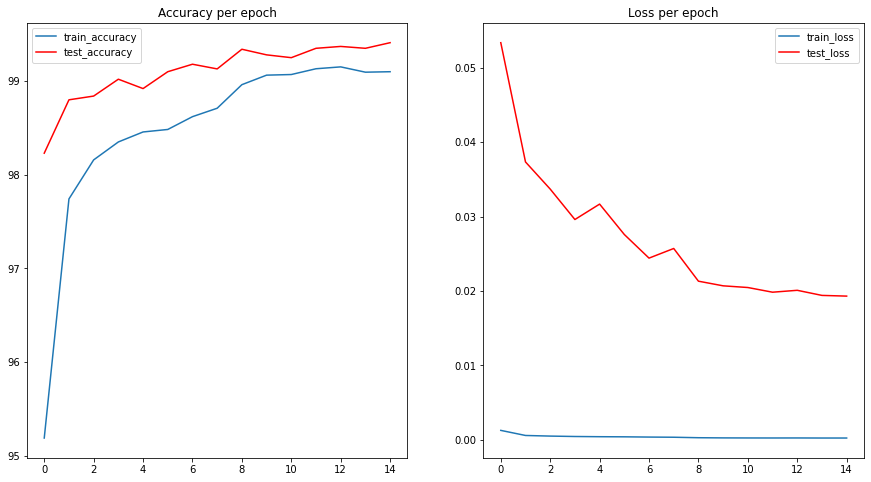

In [ ]:


import numpy as np
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [15, 8]

plt.subplot(1,2, 1)

plt.plot(np.array(train_accuracy_list))
plt.plot(np.array(test_accuracy_list), 'r')
plt.legend(["train_accuracy", "test_accuracy"])
plt.title("Accuracy per epoch")

plt.subplot(1,2,2)
plt.plot(train_loss_list)
plt.plot(test_loss_list, 'r')
plt.legend(["train_loss", "test_loss"])
plt.title("Loss per epoch")

